<a href="https://colab.research.google.com/github/CodeHunterOfficial/TimeSeriesForecast_2024-2025/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0_8_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тема 8. Прогнозирование временных рядов с помощью RNN

Постановка задач.



Анализ временных рядов, в отличие от регрессионного анализа, характеризуется отсутствием явных свидетельств о факторах, влияющих на целевые показатели. Основной особенностью анализа временных рядов является использование времени в качестве одной из ключевых переменных с целью выявления динамических изменений во времени.

Задача прогнозирования временных рядов заключается в построении модели на основе исторических данных и последующем применении этой модели для предсказания будущих значений временного ряда.

Перед переходом к описанию выбранного для исследования набора данных, необходимо импортировать ряд востребованных программных библиотек, которые будут использованы в ходе дальнейшей работы.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,5)
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, explained_variance_score, max_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

**Датасет**

Поиск в сети Интернет привел нас к выбору набора данных "Система велопроката в Лондоне", размещенного на платформе Kaggle и предоставленного Христо Маврудиевым. Этот набор данных изначально был опубликован и открыт компанией TfL (Транспорт для Лондона). Мы остановили свой выбор на этом наборе данных, поскольку он представлялся нам весьма интересным и уникальным среди прочих временных рядов, доступных онлайн. Данные были также хорошо документированы и удобны для анализа. Наша цель состоит в прогнозировании будущего количества велопрокатов на основе исторических данных по Лондону.

**Загрузка датасеть.**

На первом этапе загружаем датасет в dataFrame:

In [ ]:
df = pd.read_csv("/content/london_merged.csv",parse_dates=['timestamp'],index_col="timestamp")



Выбранный нами для анализа набор данных содержит 2 года информации о велопрокате, записанной с регулярным интервалом (1 час). Рассмотрим, сколько строк и столбцов включает в себя этот датасет.

Для начала проанализируем его размерность:

In [ ]:
print(f'Размерность датафрейма: {df.shape}')

Размерность датафрейма: (17414, 9)


<div class="alert alert-block alert-success">
Давайте теперь рассмотрим, с чего начинаются первые строки.
</div>

In [ ]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


Рассмотрим более подробно переменные, содержащиеся в нашем наборе данных:

- timestamp - временная метка, по которой сгруппированы данные;
- cnt - количество новых поездок на велосипедах;
- t1 - фактическая температура в градусах Цельсия;
- t2 - ощущаемая температура в градусах Цельсия;
- hum - влажность в процентах;
- wind_speed - скорость ветра в км/ч;
- is_holiday - булево поле, равное 1 в праздничные дни и 0 в обычные;
- is_weekend - булево поле, равное 1 в выходные дни;
- season - категориальное поле, обозначающее метеорологические сезоны: 0 - весна, 1 - лето, 2 - осень, 3 - зима.

Данное описание переменных позволит нам лучше понять структуру и содержание нашего набора данных перед тем, как приступить к дальнейшему анализу.

** Подготовка данных**

In [ ]:
df.isna().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

После тщательного изучения набора данных, мы пришли к выводу, что дополнительная очистка данных не требуется. Таким образом, мы можем переходить к следующему этапу анализа без внесения каких-либо изменений в исходный датасет.

Поскольку исходные данные были предоставлены в хорошем качестве и не содержали очевидных проблем, таких как пропущенные значения или выбросы, мы можем продолжить работу с текущей версией набора данных.

Отсутствие необходимости в этапе предварительной обработки данных позволит нам сосредоточиться на дальнейших шагах моделирования и прогнозирования.

**Создание признаков**

На основе имеющегося временного признака (timestamp) мы сконструировали несколько новых переменных, которые могут помочь в дальнейшем анализе:

In [ ]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

Эти дополнительные признаки, основанные на временных характеристиках, позволят нам более детально изучить влияние временных факторов на количество велопрокатов.

Теперь, после небольшого этапа инженерии признаков, мы готовы перейти к более глубокому исследованию данных.

**Анализ данных**

Начнем с простого визуального анализа динамики велопрокатов во времени:

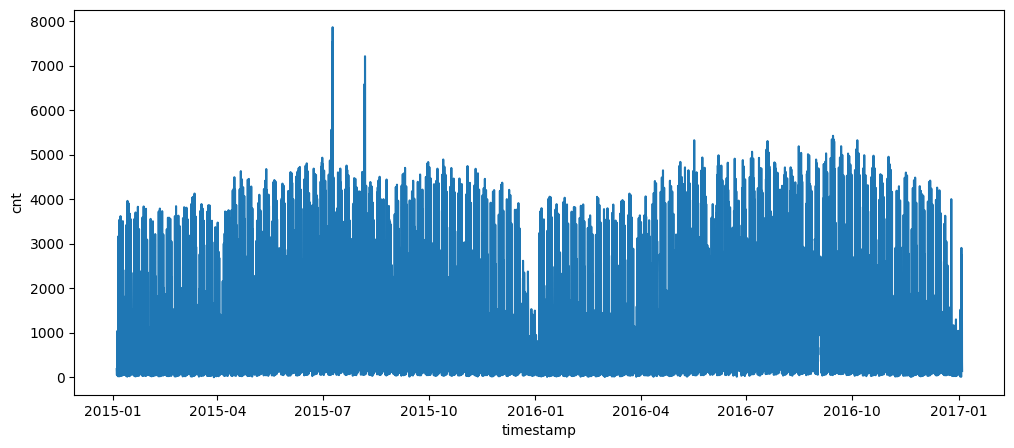

In [ ]:
sns.lineplot(x=df.index, y='cnt', data=df)
plt.show()

Графическое отображение вышеприведенных данных, к сожалению, не позволяет нам сделать четкие выводы, поскольку показатели продаж велосипедов не являются столь очевидными. Следовательно, представляется целесообразным рассмотреть те же сведения, но с разбивкой на ежемесячной основе.

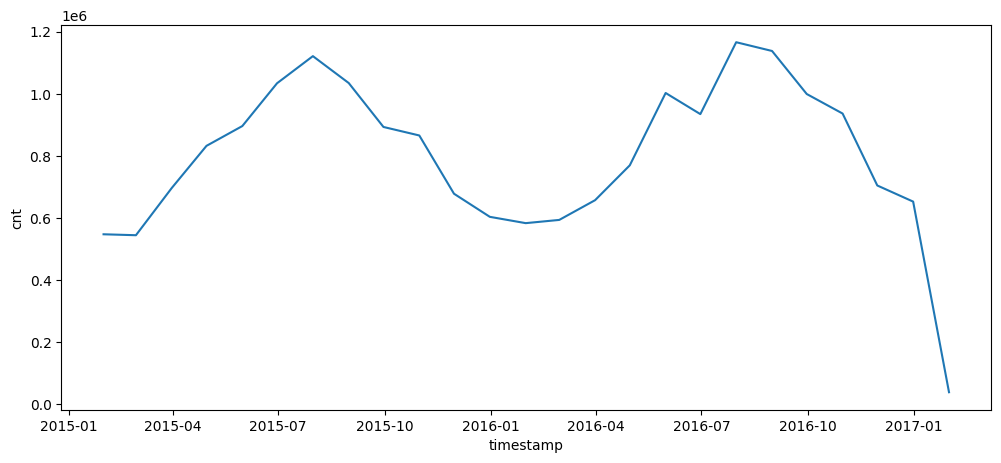

In [ ]:
df_by_month = df.resample('M').sum()
sns.lineplot(x=df_by_month.index, y='cnt', data=df_by_month)
plt.show()

<div class="alert alert-block alert-success">
В летние месяцы кажется, что продажи велосипедов выше, чем в другие времена года. Давайте также посмотрим на количество аренды велосипедов по часам и проверим, влияют ли праздники и выходные на количество аренды велосипедов.
</div>

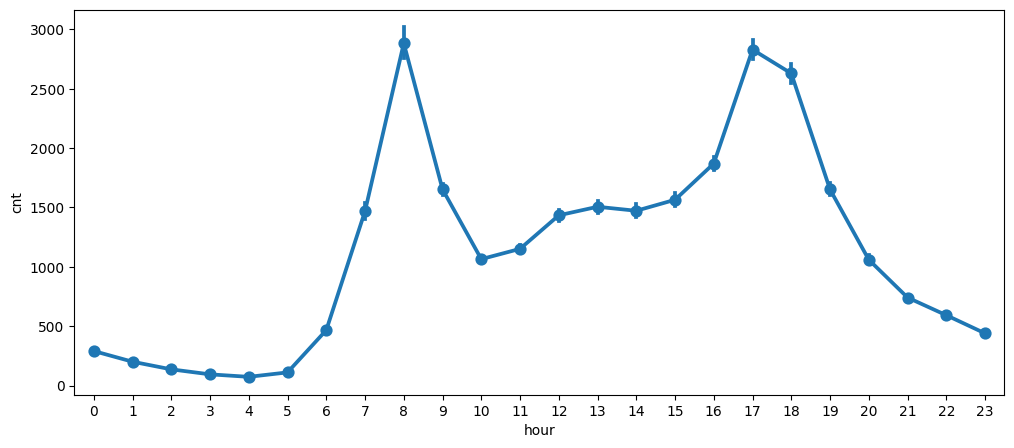

In [ ]:
sns.pointplot(x='hour', y='cnt', data=df)
plt.show()

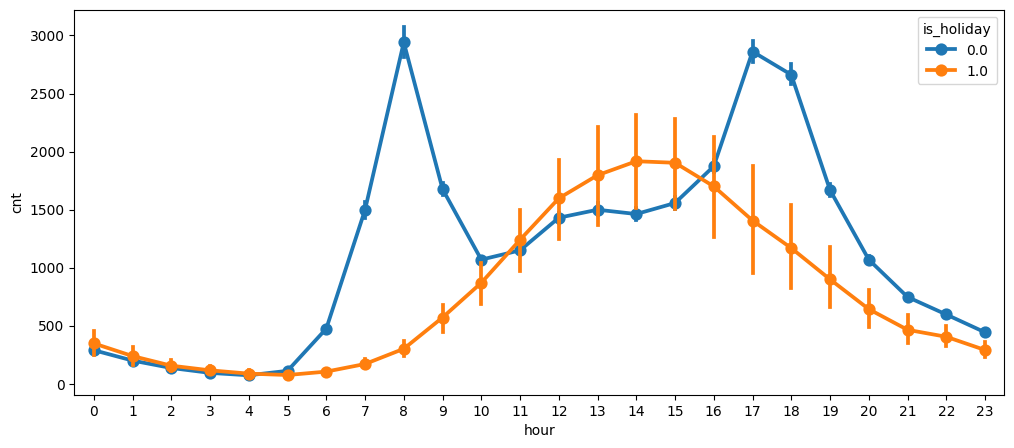

In [ ]:
sns.pointplot(x='hour', y='cnt', data=df, hue='is_holiday')
plt.show()

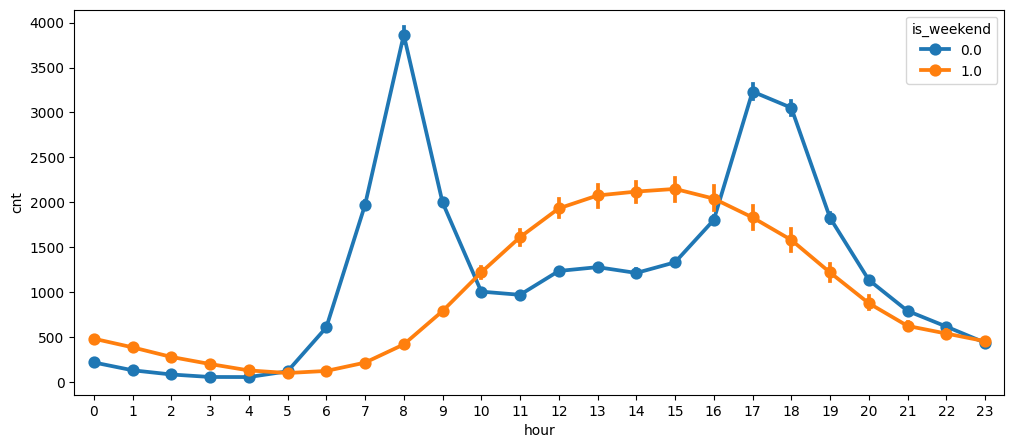

In [ ]:
sns.pointplot(x='hour', y='cnt', data=df, hue='is_weekend')
plt.show()

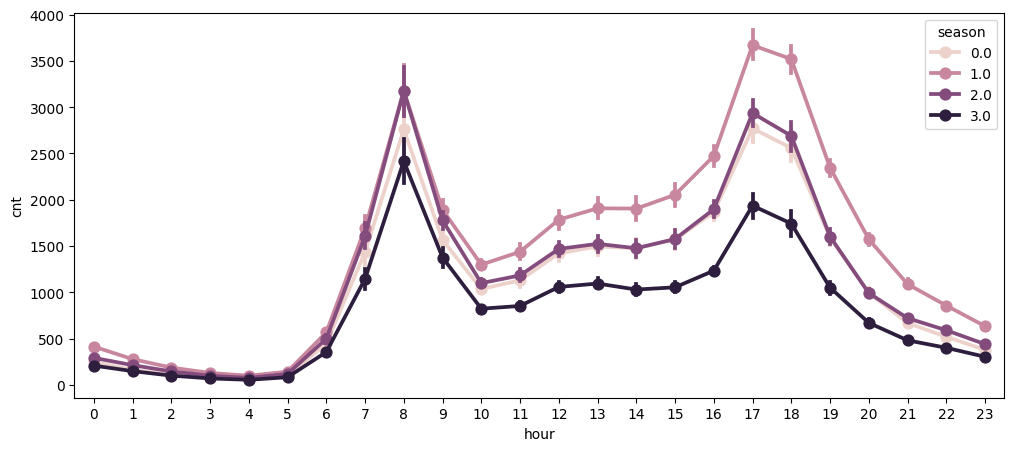

In [ ]:
sns.pointplot(x='hour', y='cnt', data=df, hue='season')
plt.show()

<div class="alert alert-block alert-success">
Время, когда наблюдается наибольшее количество аренд велосипедов, значительно различается в зависимости от того, является ли это выходным или будним днем. В рабочие дни заметны два выраженных пика — один утром и другой в поздние послеобеденные часы. В выходные же наиболее загруженное время приходится на дневные часы.
</div>

<div class="alert alert-block alert-success">
Давайте также посмотрим на данные по дням недели.
</div>

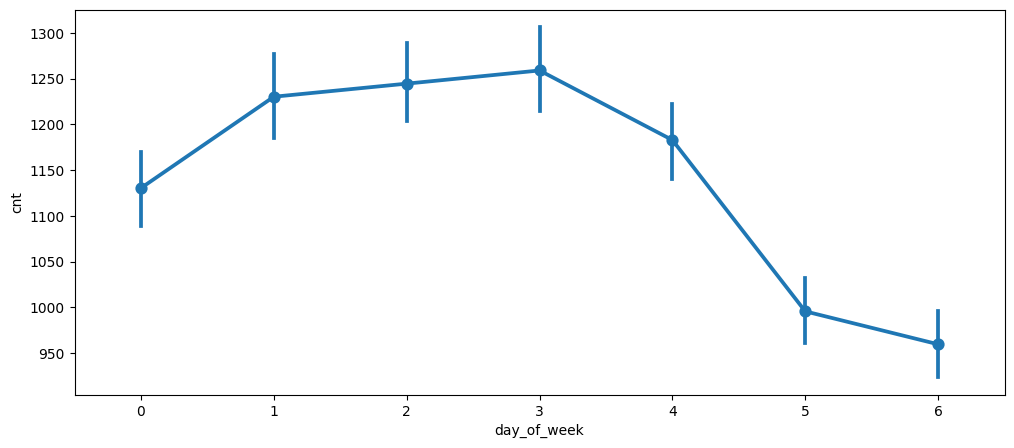

In [ ]:
sns.pointplot(x='day_of_week', y='cnt', data=df)
plt.show()

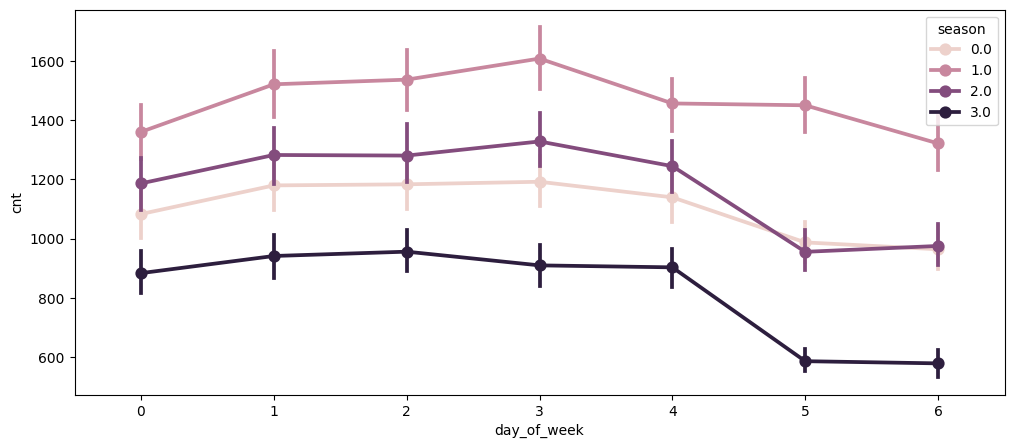

In [ ]:
sns.pointplot(x='day_of_week', y='cnt', data=df, hue='season')
plt.show()

<div class="alert alert-block alert-success">
Анализируя приведенные графики, можно заметить, что в рабочие дни (с понедельника по пятницу) количество арендованных велосипедов значительно выше.
</div>

Раздел 5. Подготовка данных для обучения модели

Перед тем, как приступить к обучению машинной модели, необходимо разбить исходный набор данных на две отдельные части: тренировочный и тестовый наборы.

Типичное соотношение между тренировочным и тестовым наборами может составлять 70:30, 80:20 или 90:10. Это означает, что 70%, 80% или 90% данных используется для обучения модели, а оставшиеся 30%, 20% или 10% - для ее тестирования. Процесс разбиения данных может варьироваться в зависимости от формы и размера исходного набора.

В нашем случае мы будем использовать последние 10% данных для тестирования модели, а остальные 90% - для ее обучения.

In [ ]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 15672
Test size: 1742


<div class="alert alert-block alert-success">
На данном этапе мы масштабируем некоторые признаки, которые будем использовать для нашего моделирования, а также количество арендованных велосипедов, которое хотим предсказать. Для этого мы применим RobustScaler из библиотеки sklearn, так как он менее подвержен влиянию выбросов:
</div>

In [ ]:
cols = ['t1', 't2', 'hum', 'wind_speed']

scaler = RobustScaler()
scaler = scaler.fit(np.asarray(train[cols]))

train.loc[:, cols] = scaler.transform(np.asarray(train[cols]))
test.loc[:, cols] = scaler.transform(np.asarray(test[cols]))


In [ ]:
cnt_scaler = RobustScaler()
cnt_scaler = cnt_scaler.fit(train[['cnt']])
train['cnt'] = cnt_scaler.transform(train[['cnt']])
test['cnt'] = cnt_scaler.transform(test[['cnt']])

In [ ]:
print('Train shape:',train.shape)
print('Test shape:', test.shape)

Train shape: (15672, 13)
Test shape: (1742, 13)


<div class="alert alert-block alert-info">
<b>Обратите внимание, что мы не масштабируем категориальные переменные.</b>
</div>

Раздел 6. Искусственные нейронные сети для прогнозирования временных рядов

Традиционно, прогнозирование временных рядов было сосредоточено на линейных методах, поскольку они хорошо изучены и эффективны для многих более простых задач прогнозирования.

Однако глубокие нейронные сети способны автоматически обучаться произвольно сложным отображениям от входов к выходам и поддерживают множественные входы и выходы.

Наиболее распространенными искусственными нейронными сетями, которые могут использоваться для прогнозирования временных рядов, являются:

- Рекуррентные нейронные сети (РНС), включая LSTM и GRU как наиболее распространенные их разновидности.

Каждая из этих моделей имеет свои преимущества и недостатки. Мы построим все вышеперечисленные модели, обучим их и попытаемся предсказать количество велопрокатов, чтобы определить, какая из них показывает лучшие результаты.

Для подготовки последовательностей данных, подходящих для различных искусственных нейронных сетей, мы определим функцию, которая будет преобразовывать наш набор данных в формат [samples, time_steps, n_features], требуемый для РНС.

Здесь:
- Samples - длина данных или количество точек данных
- Time steps - число временных шагов, для которых будет помнить рекуррентная сеть
- Features - количество признаков, подаваемых в каждый временной шаг

Затем мы применим эту функцию к тренировочным и тестовым данным.

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

<div class="alert alert-block alert-info">
Каждая нейронная сеть в TensorFlow требует специфической формы ввода, поэтому при необходимости мы будем изменять форму наших данных перед подачей в сеть.</div>

In [ ]:
time_steps = 10
# reshape to [samples, time_steps, features]
X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)
print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


##### <div class="alert alert-block alert-danger"><h1>LSTM (Long Short-Term Memory)</h1></div>

Долгая краткосрочная память (LSTM) - это архитектура рекуррентной нейронной сети (РНС), впервые предложенная Hochreiter и Jürgen Schmidhuber в 1997 году, которая запоминает значения в течение произвольных интервалов времени. LSTM хорошо подходит для классификации, обработки и прогнозирования временных рядов при неизвестной длительности временных интервалов.

Рекуррентные нейронные сети, такие как LSTM, добавляют явную обработку порядка между наблюдениями при обучении функции отображения от входов к выходам, чего не предлагают многослойные персептроны (МЛП) или сверточные нейронные сети (СНС). Они являются типом нейронных сетей, которые добавляют встроенную поддержку для входных данных, состоящих из последовательностей наблюдений. LSTM также может обучаться временной зависимости. Модель одновременно обучает отображение от входов к выходам и изучает, какой контекст из входной последовательности полезен для этого отображения, и может динамически изменять этот контекст по мере необходимости.

Давайте построим нашу модель LSTM. Чтобы сделать нашу модель LSTM устойчивой к изменениям, используется функция Dropout. Dropout(0.2) случайно отключает 20% единиц из сети. Давайте повторим те же шаги для этой нейронной сети.

In [ ]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.Dense(units=1))
lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
lstm_history = lstm_model.fit(X_train, y_train,epochs=50,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/50
441/441 [==============================] - 13s 22ms/step - loss: 0.2475 - val_loss: 0.1866
Epoch 2/50
441/441 [==============================] - 9s 20ms/step - loss: 0.0843 - val_loss: 0.0813
Epoch 3/50
441/441 [==============================] - 7s 16ms/step - loss: 0.0577 - val_loss: 0.0605
Epoch 4/50
441/441 [==============================] - 8s 19ms/step - loss: 0.0470 - val_loss: 0.0466
Epoch 5/50
441/441 [==============================] - 8s 18ms/step - loss: 0.0331 - val_loss: 0.0444
Epoch 6/50
441/441 [==============================] - 7s 17ms/step - loss: 0.0274 - val_loss: 0.0455
Epoch 7/50
441/441 [==============================] - 9s 20ms/step - loss: 0.0255 - val_loss: 0.0353
Epoch 8/50
441/441 [==============================] - 7s 15ms/step - loss: 0.0218 - val_loss: 0.0320
Epoch 9/50
441/441 [==============================] - 9s 20ms/step - loss: 0.0213 - val_loss: 0.0342
Epoch 10/50
441/441 [==============================] - 7s 15ms/step - loss: 0.0205 - val_l

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               72704     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 72833 (284.50 KB)
Trainable params: 72833 (284.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


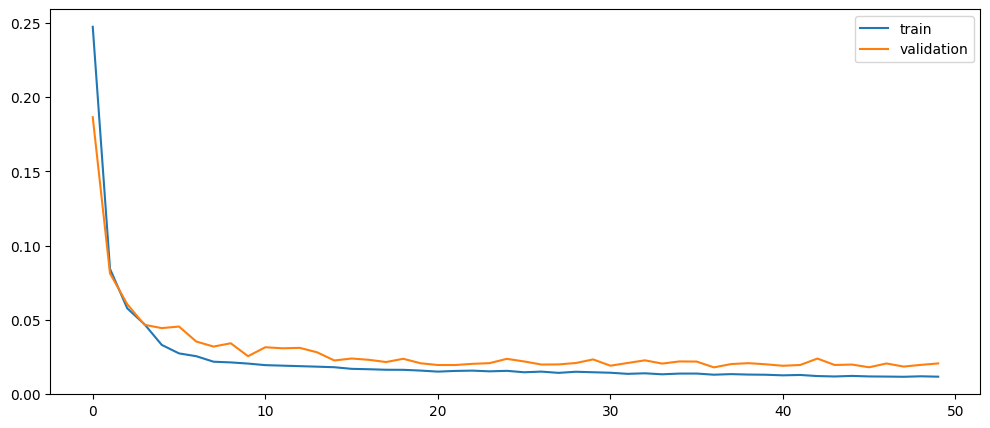

In [ ]:
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
y_pred = lstm_model.predict(X_test)
y_train_inv = cnt_scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_scaler.inverse_transform(y_pred)

55/55 [==============================] - 1s 6ms/step


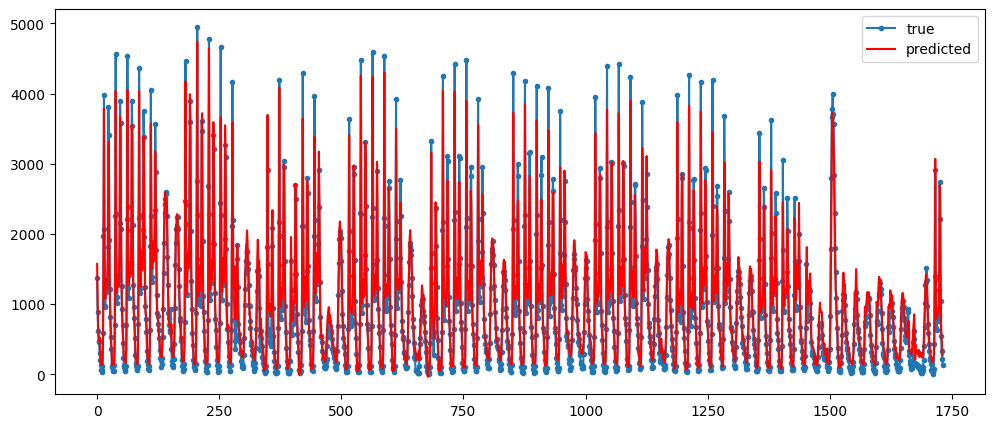

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r', label='predicted')
plt.legend()
plt.show()

In [ ]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, lstm_test_pred)))
print('MSE:', mean_squared_error(y_test, y_pred))
print('Explained variance score:', explained_variance_score(y_test, y_pred))
print('Max error:', max_error(y_test, y_pred))

55/55 [==============================] - 0s 6ms/step
Train RMSE: 0.1368279217941702
Test RMSE: 0.14433706038746766
MSE: 0.020833187001295484
Explained variance score: 0.9524426580040144
Max error: 0.6860040452526293


Применение рекуррентной нейронной сети на основе долгой краткосрочной памяти (LSTM) для моделирования данного временного ряда показало следующие результаты:

Среднеквадратическая ошибка (RMSE) на обучающей выборке составила 0,12970951944961076. Это значение характеризует точность прогнозирования модели на данных, использованных для ее тренировки.

На тестовой выборке RMSE составила 0,13728406506157723. Этот показатель отражает способность LSTM-модели обобщать полученные знания и делать точные предсказания на новых, неизвестных ранее данных.

Среднее квадратическое отклонение (MSE) равно 0,018846914519831368. Этот метрика описывает разброс прогнозных значений относительно фактических данных.

Коэффициент объясненной дисперсии (Explained variance score) достиг 0,9538968496163226. Данный показатель демонстрирует, что LSTM-модель смогла объяснить порядка 95% дисперсии целевой переменной.

Максимальная абсолютная ошибка (Max error) равна 0,7555702169407826. Этот метрик характеризует наибольшее отклонение прогнозного значения от истинного.

Полученные результаты свидетельствуют о высоком качестве моделирования временного ряда с помощью LSTM-сети. Однако, как указывалось ранее, простая модель на основе многослойного персептрона (MLP) продемонстрировала сопоставимые, а в некоторых случаях и более высокие показатели качества. Это может быть связано с особенностями данного временного ряда, который, вероятно, лучше описывается более простыми нелинейными функциями, чем сложной динамикой, присущей рекуррентным нейронным сетям.

##### <div class="alert alert-block alert-danger"><h1>GRU (Gated Recurrent Unit)</h1></div>

Единицы рекуррентной памяти с вентилями (Gated Recurrent Units, GRU) представляют собой механизм управления вентилями в рекуррентных нейронных сетях, предложенный в 2014 году Кьюнхёном Чо и соавторами. GRU аналогичны долгой краткосрочной памяти (Long Short-Term Memory, LSTM) с вентилем забывания, но имеют меньшее число параметров, поскольку не содержат выходного вентиля. Было установлено, что производительность GRU при решении некоторых задач моделирования полифонической музыки, моделирования речевого сигнала и обработки естественного языка сопоставима с LSTM. Показано, что GRU демонстрируют лучшую производительность на некоторых более небольших и менее частотных наборах данных.

Ключевые отличия между LSTM и GRU:

LSTM (Long Short Term Memory): LSTM имеет три вентиля (входной, выходной и вентиль забывания).

GRU (Gated Recurring Units): GRU имеет два вентиля (сброса и обновления).

GRU объединяет вентили забывания и входа. GRU используют меньше обучаемых параметров и, следовательно, потребляют меньше памяти, работают быстрее и обучаются быстрее, чем LSTM, в то время как LSTM более точны на наборах данных с более длинными последовательностями. Иными словами, если последовательность велика или точность критически важна, мы склонны использовать LSTM, а для меньшего потребления памяти и более быстрой работы обычно используем GRU. LSTM имеет три значения на выходе (выход, скрытое и ячейка), в то время как GRU имеет два значения на выходе (выход и скрытое).

Давайте теперь попробуем построить нашу GRU-нейронную сеть.

In [ ]:
gru_model = tf.keras.Sequential()
gru_model.add(tf.keras.layers.GRU(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(tf.keras.layers.Dropout(rate=0.2))
gru_model.add(tf.keras.layers.Dense(units=1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               54912     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 55041 (215.00 KB)
Trainable params: 55041 (215.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
gru_history = gru_model.fit(X_train, y_train,epochs=50,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/50
441/441 [==============================] - 8s 13ms/step - loss: 0.3860 - val_loss: 0.2164
Epoch 2/50
441/441 [==============================] - 7s 16ms/step - loss: 0.1581 - val_loss: 0.1189
Epoch 3/50
441/441 [==============================] - 5s 12ms/step - loss: 0.0860 - val_loss: 0.0509
Epoch 4/50
441/441 [==============================] - 7s 16ms/step - loss: 0.0503 - val_loss: 0.0332
Epoch 5/50
441/441 [==============================] - 5s 12ms/step - loss: 0.0399 - val_loss: 0.0346
Epoch 6/50
441/441 [==============================] - 6s 15ms/step - loss: 0.0338 - val_loss: 0.0254
Epoch 7/50
441/441 [==============================] - 6s 14ms/step - loss: 0.0299 - val_loss: 0.0248
Epoch 8/50
441/441 [==============================] - 5s 12ms/step - loss: 0.0281 - val_loss: 0.0275
Epoch 9/50
441/441 [==============================] - 7s 16ms/step - loss: 0.0250 - val_loss: 0.0283
Epoch 10/50
441/441 [==============================] - 5s 12ms/step - loss: 0.0242 - val_lo

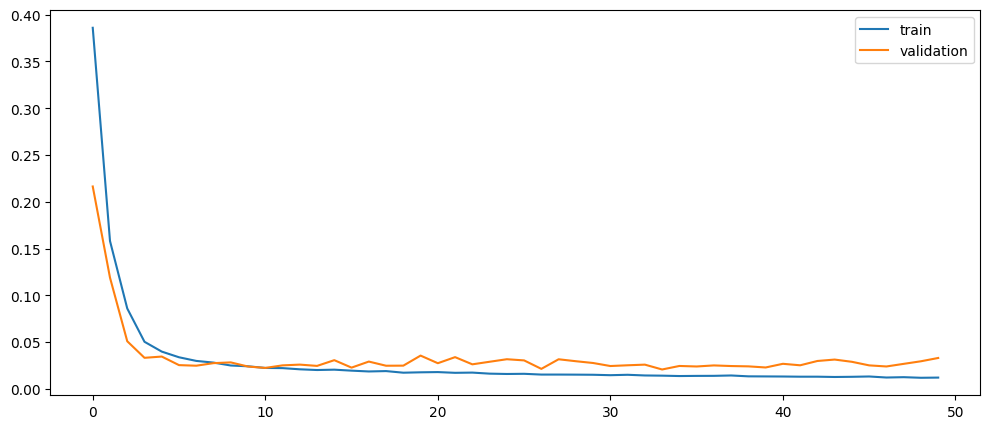

In [ ]:
plt.plot(gru_history.history['loss'], label='train')
plt.plot(gru_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
y_pred = gru_model.predict(X_test)
y_train_inv = cnt_scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_scaler.inverse_transform(y_pred)

55/55 [==============================] - 1s 4ms/step


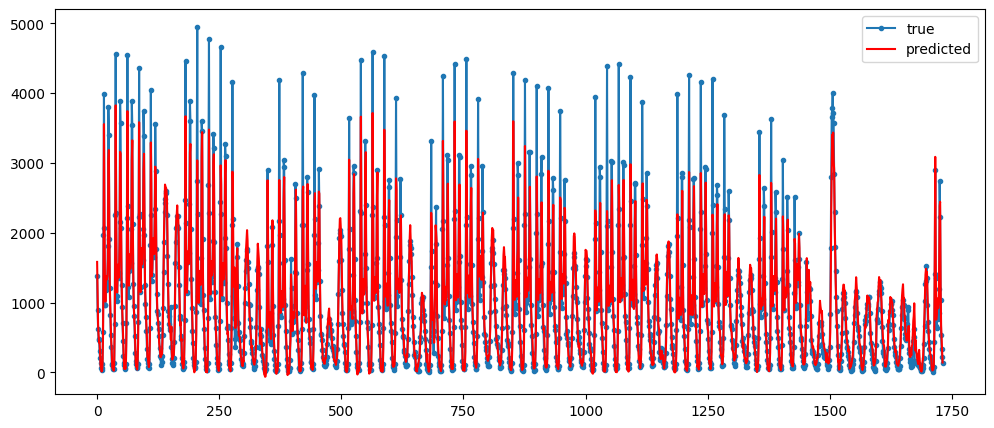

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r', label='predicted')
plt.legend()
plt.show()

In [ ]:
gru_train_pred = gru_model.predict(X_train)
gru_test_pred = gru_model.predict(X_test)
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, gru_train_pred)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, gru_test_pred)))
print('MSE:', mean_squared_error(y_test, y_pred))
print('Explained variance score:', explained_variance_score(y_test, y_pred))
print('Max error:', max_error(y_test, y_pred))

55/55 [==============================] - 0s 4ms/step
Train RMSE: 0.13823020824660645
Test RMSE: 0.20779991797034428
MSE: 0.04318080590848181
Explained variance score: 0.8948198376041676
Max error: 1.4286308167066126


Раздел 7. Выводы и наблюдения (продолжение)

Мы можем заметить, что производительность GRU достаточно схожа с производительностью LSTM. Тем не менее, LSTM показал несколько лучшие результаты по сравнению с GRU. Таким образом, мы подтверждаем тот факт, что LSTM является моделью, которая обеспечивает большую точность, как это уже известно.

LSTM обладают рядом особенностей, которые делают их более эффективными для моделирования временных рядов по сравнению с другими типами рекуррентных нейронных сетей, таких как GRU. Ключевые преимущества LSTM включают в себя:

1. Более сложный механизм обработки последовательностей, позволяющий избегать проблемы исчезающего или взрывного градиента.
2. Способность избирательно запоминать и забывать важную информацию из предыдущих шагов.
3. Использование так называемых "ворот" (gates), которые лучше контролируют поток информации внутри ячеек LSTM.

Эти особенности дают LSTM преимущество в моделировании долгосрочных зависимостей в данных временных рядов по сравнению с более простыми моделями, такими как GRU.



Ниже мы приводим список протестированных рекуррентных нейронных сетей, их обучаемые параметры и показатели объясненной дисперсии, расположенные от лучшего к худшему:

Искусственная нейронная сеть | Обучаемые параметры | Показатель объясненной дисперсии
--- | --- | ---
LSTM | 72,833 | 0.9519
GRU | 55,041 | 0.9389


Таким образом, результаты нашего исследования подтверждают, что LSTM, как правило, демонстрируют более высокую точность при решении задач прогнозирования временных рядов по сравнению с другими распространенными архитектурами рекуррентных нейронных сетей.